# Heads-Up

In the notebook, we are working on generating
graphs whose nodes have Euclidean coordinates;
One thing to pay attention to is, in real world
road network, nodes (intersections) that are close
to each other geographically are more likely to be
connected with edges (roads).

Edge centrality will be added as part of the heuristic.

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import plot_g

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-12 21:25:47.764793. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [10]:
NUM_NODE = 100
WEIGHT_MIN = .0
WEIGHT_MAX = 1.

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-12 21:52:52.248342. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [48]:
def generate_low_degree_g(node_size=20, min_out_degree=2, max_out_degree=4, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):
    
    G = nx.Graph()
    
    grid_size = 1000
    euclidean_coords = np.linspace(0.01, 1.0, num=grid_size, endpoint=False)
    coords_indices = list(range(grid_size))
    
    random.shuffle(coords_indices)
    x_coords = euclidean_coords[coords_indices][:node_size]
#     print(x_coords)
    random.shuffle(coords_indices)
    y_coords = euclidean_coords[coords_indices][:node_size]
#     print(y_coords)
    
    # Add coordinates to nodes
    for node, coord in enumerate(zip(x_coords, y_coords)):
        G.add_node(node, x=coord[0], y=coord[1])
    
    for node in G.nodes:
        
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        random.shuffle(tmp_nodes)
        num_of_neighbors = random.randint(min_out_degree, max_out_degree)
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for tmp_node in tmp_nodes:

            if G.degree(tmp_node) >= max_out_degree \
                or G.degree(node) >= num_of_neighbors:
                # This node has maximum number of neighbors already
                continue
            
            weight = random.uniform(weight_min, weight_max)
            G.add_edge(node, tmp_node, weight=weight)
    
    # Add centrality to edges
    edge_centrality = nx.edge_betweenness_centrality(G, \
                                                     k=G.number_of_nodes(), \
                                                     weight='weight')
    assert len(edge_centrality) == G.number_of_edges()
    
    for edge_data in G.edges.data():
        edge_data[2]['centrality'] = edge_centrality[(edge_data[0], edge_data[1])]
        
    return G

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-12 22:02:24.862551. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [55]:
G = generate_low_degree_g()

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-12 22:02:56.308298. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-12 22:02:56.725569. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


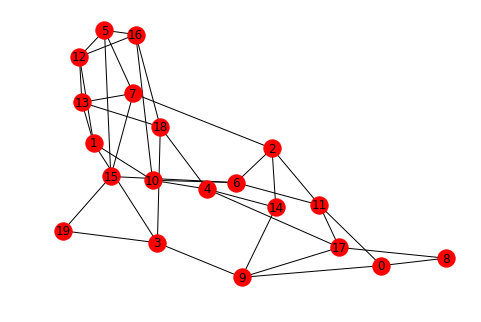

In [56]:
plot_g(G)